# Meet's code

## 1. Import Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, gc
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
import random

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K
print("Tensorflow version: ",tf.__version__)

# from transformers import *

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_error

from tqdm import tqdm 
import itertools

SEED = 2020

def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

seed_everything(SEED)

ModuleNotFoundError: No module named 'tensorflow_addons'

In [2]:
AUGMENTED = True
OHE = False

## 2. Load Data

In [3]:
PATH = '/kaggle/input/stanford-covid-vaccine'
os.listdir(PATH)

['test.json', 'train.json', 'sample_submission.csv', 'bpps']

In [4]:
train = pd.read_json(os.path.join(PATH,'train.json'),lines=True).drop('index',axis=1)
test = pd.read_json(os.path.join(PATH,'test.json'),lines=True).drop('index',axis=1)
sub = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

In [5]:
if AUGMENTED:
    train = pd.read_json('../input/openvaccine/train.json').drop('index',axis=1)
    test = pd.read_json('../input/openvaccine/test.json').drop('index',axis=1)
    test = test[test.cnt==1]

In [6]:
def get_bppm(id_):
    return np.load(os.path.join(PATH,f"bpps/{id_}.npy"))

In [7]:
train.head().T

,0,1,2,3,4
level_0,0,1,2,3,4
id,id_001f94081,id_0049f53ba,id_006f36f57,id_0082d463b,id_0087940f4
sequence,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...
structure,.....((((((.......)))).)).((.....((..((((((......,.....(((((((((((((((((((((((....)))))))))).)))...,.....((((.((.....((((.(((.....)))..((((......)...,......((((((((((((((((......))))))))))))))))((...,.....(((((((.((((((((((((.(((((((((....)))))))...
signal_to_noise,6.894,0.193,8.8,0.104,0.423
SN_filter,1,0,1,0,0
seq_length,107,107,107,107,107
seq_scored,68,68,68,68,68
reactivity_error,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[0.0931, 0.13290000000000002, 0.11280000000000...","[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000..."
deg_error_Mg_pH10,"[0.26130000000000003, 0.38420000000000004, 0.1...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1..."


## 3. Preprocessing

In [8]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
feature_cols = ['sequence', 'structure', 'predicted_loop_type']

In [9]:
# Filter the train data
# train = train[train.signal_to_noise>1]
# train = train[train.SN_filter==1]

In [10]:
# def get_stratify_group(row):
#     snf = row['SN_filter']
#     snr = row['signal_to_noise']
    
#     if snf == 0:
#         if snr<0:
#             snr_c = 0
#         elif 0<= snr < 2:
#             snr_c = 1
#         elif 2<= snr < 4:
#             snr_c = 2
#         elif 4<= snr < 5.5:
#             snr_c = 3
#         elif 5.5<= snr < 10:
#             snr_c = 4
#         elif snr >= 10:
#             snr_c = 5
            
#     else: # snf == 1
#         if snr<2.5:
#             snr_c = 6
#         elif 2.5<= snr < 7.5:
#             snr_c = 7
#         elif 7.5<= snr < 11:
#             snr_c = 8
#         elif snr >= 11:
#             snr_c = 9
        
#     return '{}'.format(snr_c)

def get_stratify_group(row):
    snf = row['SN_filter']
    snr = row['signal_to_noise']
    
    if snf == 0:
        if snr<0:
            snr_c = 0
        elif 0<= snr < 2:
            snr_c = 1
        elif 2<= snr < 4:
            snr_c = 2
        elif 4<= snr < 5.5:
            snr_c = 3
        elif 5.5<= snr < 10:
            snr_c = 4
        elif snr >= 10:
            snr_c = 5
            
    else: # snf == 1
        if snr < 2:
            snr_c = 6
        elif 2<= snr < 3:
            snr_c = 7
        elif 3<= snr < 4:
            snr_c = 8
        elif 4<= snr < 5:
            snr_c = 9
        elif 5<= snr < 6:
            snr_c = 10
        elif 6<= snr < 7:
            snr_c = 11
        elif 7<= snr < 8:
            snr_c = 12
        elif 8<= snr < 9:
            snr_c = 13
        elif 9<= snr < 10:
            snr_c = 14
        elif snr >= 10:
            snr_c = 15
        
    return snr_c


train['snr_stratify_group'] = train.apply(get_stratify_group,axis=1)

In [11]:
# Some new features

# Next or Prev loop type
def getNextOrPrevLoop(df,NEXT=True):
    data = []
    for index in range(df.shape[0]):
        predicted_loop_type = df.iloc[index]['predicted_loop_type']
        if NEXT:
            predicted_loop_type = predicted_loop_type[::-1]
        
        prevLoop = '-'
        nextLoop = [prevLoop]
        for i in range(1,len(predicted_loop_type)):
            curr = predicted_loop_type[i]
            prev = predicted_loop_type[i-1]
            
            if curr != prev:
                prevLoop = prev
            
            nextLoop.append(prevLoop)
        
        if NEXT:
            nextLoop = nextLoop[::-1]

        data.append("".join(nextLoop))
    
    return data


def getPairedWith(df):
    data = []
    bppsData = []
    absDistData = []
    
    # Adjacent pair type
    prevPairData = []
    nextPairData = []

    for index in range(df.shape[0]):
        sequence = df.iloc[index]['sequence']
        structure = df.iloc[index]['structure']
        
        bpps = get_bppm(df.iloc[index]['id'])

        pairedWith = ['#']*len(sequence)
        bpp = [-1]*len(sequence)
        abs_dist = [-1]*len(sequence)
        pairIndex = [-1]*len(sequence)
        
        stack = []
        for i in range(len(sequence)):
            if structure[i] == '(':
                stack.append(i)
            elif structure[i] == ')':
                j = stack.pop(-1)
                
                pairIndex[i] = j
                pairIndex[j] = i
                
                pairedWith[j] = sequence[i]
                pairedWith[i] = sequence[j]
                
                bpp[j] = bpps[j][i]
                bpp[i] = bpps[i][j]
                
                abs_dist[j] = abs(i-j)
                abs_dist[i] = abs(i-j)
        
        prevPair = [-1]*len(sequence)
        nextPair = [-1]*len(sequence)
        for i in range(len(sequence)):
            if i-1>=0 and pairIndex[i-1]!=-1:
                prevPair[i] = (sequence[i-1],sequence[pairIndex[i-1]])
            if i+1<len(sequence) and pairIndex[i+1]!=-1:
                nextPair[i] = (sequence[i+1],sequence[pairIndex[i+1]])
        
        prevPairData.append(prevPair)
        nextPairData.append(nextPair)
        
        data.append("".join(pairedWith))
        bppsData.append(bpp)
        absDistData.append(abs_dist)
    
    return data, bppsData, absDistData, prevPairData, nextPairData

def getBPPFeatures(df):
    maxs = []
    means = []
    argmaxs = []
    sums = []
    nonzero = []
    
    for index in range(df.shape[0]):
        bpps = get_bppm(df.iloc[index].id)
        
        maxs.append(np.max(bpps,axis=-1))
        means.append(np.mean(bpps,axis=-1))
        argmaxs.append(np.argmax(bpps,axis=-1))
        sums.append(np.sum(bpps,axis=-1))
        nonzero.append((bpps>0).mean(axis=-1))
        
    return maxs, means, argmaxs, sums, nonzero

def getNeighbourBPP(df):
    dataB = [] # BPP with Prev Base
    dataA = [] # BPP with Next Base
    
    for index in range(df.shape[0]):
        bpps = get_bppm(df.iloc[index].id)
        seq_length = df.iloc[index].seq_length
        
        B = [-1]*seq_length
        A = [-1]*seq_length
        
        for i in range(seq_length):
            
            if i-1>=0:
                B[i] = bpps[i][i-1]
            if i+1<seq_length:
                A[i] = bpps[i][i+1]
            
        dataB.append(B)
        dataA.append(A)
    
    return dataB, dataA

# Minimum Pair Distance from Stem-ends
def getMinPairDist(df):
    data = []
    
    for index in range(df.shape[0]):
        structure = df.iloc[index].structure
        seq_length = df.iloc[index].seq_length
        
        dist = [-1]*seq_length
        
        a = 0
        if structure[0] in ['(',')']:
            dist[0] = a
        for i in range(1,seq_length):
            curr = structure[i]
            if curr in ['(',')']:
                if curr==structure[i-1]:
                    a += 1
                else:
                    a = 0
                dist[i] = a
        
        structure = structure[::-1]
        
        a = 0
        if structure[0] in ['(',')']:
            dist[seq_length - 0 - 1] = a
        for i in range(1,seq_length):
            curr = structure[i]
            if curr in ['(',')']:
                if curr==structure[i-1]:
                    a += 1
                else:
                    a = 0
                dist[seq_length - i-1] = min(a,dist[seq_length - i-1])
        
        data.append(dist)
            
    return data

In [12]:
"""https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn"""

def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def getOHEInput(df):
    
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(df["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    if 'pairedWith' in df.columns:
        mapping = {}
        vocab = ["A", "G", "C", "U", "#"]
        for i, s in enumerate(vocab):
            mapping[s] = return_ohe(len(vocab), i)
        X_paired = np.stack(df['pairedWith'].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
        
        X_node = np.concatenate([X_node,X_paired],axis=2)

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
#     if AUGMENTED:
#         vocab = ['s','h','f','t','i','m']
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(df["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    mapping = {}
    vocab = [".", "(", ")"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_structure = np.stack(df["structure"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    X_node = np.concatenate([X_node, X_loop, X_structure], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    # print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    # print(X_node.shape)
    
    return X_node

In [13]:
s = set(['A','C','G','U'])
pairTypeDict = dict(zip(list(itertools.product(s,s)),range(len(s)**2)))

pairTypeDict

{('C', 'C'): 0,
 ('C', 'G'): 1,
 ('C', 'A'): 2,
 ('C', 'U'): 3,
 ('G', 'C'): 4,
 ('G', 'G'): 5,
 ('G', 'A'): 6,
 ('G', 'U'): 7,
 ('A', 'C'): 8,
 ('A', 'G'): 9,
 ('A', 'A'): 10,
 ('A', 'U'): 11,
 ('U', 'C'): 12,
 ('U', 'G'): 13,
 ('U', 'A'): 14,
 ('U', 'U'): 15}

In [14]:
new_features = []
separate_features = []

# train['nextLoopType'] = getNextOrPrevLoop(train)
# train['prevLoopType'] = getNextOrPrevLoop(train,NEXT=False)

# test['nextLoopType'] = getNextOrPrevLoop(test)
# test['prevLoopType'] = getNextOrPrevLoop(test,NEXT=False)

# new_features += ['nextLoopType','prevLoopType']

train_pw_f = getPairedWith(train)
test_pw_f = getPairedWith(test)

train['pairedWith'],test['pairedWith'] = train_pw_f[0], test_pw_f[0]; new_features += ['pairedWith']
train['bpp'], test['bpp'] = train_pw_f[1], test_pw_f[1]; separate_features += ['bpp']
train['abs_dist'], test['abs_dist'] = train_pw_f[2], test_pw_f[2]; separate_features += ['abs_dist']

feature_cols += new_features

train_bpp_f = getBPPFeatures(train)
test_bpp_f = getBPPFeatures(test)

train_neighbour_bpp = getNeighbourBPP(train)
test_neighbour_bpp = getNeighbourBPP(test)

train['bpp_maxs'], test['bpp_maxs'] = train_bpp_f[0], test_bpp_f[0]; separate_features += ['bpp_maxs']
train['bpp_means'], test['bpp_means'] = train_bpp_f[1], test_bpp_f[1]; separate_features += ['bpp_means']
# train['bpp_argmaxs'], test['bpp_argmaxs'] = train_bpp_f[2], test_bpp_f[2]; separate_features += ['bpp_argmaxs']
train['bpp_sums'], test['bpp_sums'] = train_bpp_f[3], test_bpp_f[3]; separate_features += ['bpp_sums']

# train['bpp_before'], test['bpp_before'] = train_neighbour_bpp[0], test_neighbour_bpp[0]; separate_features += ['bpp_before']
train['bpp_after'], test['bpp_after'] = train_neighbour_bpp[1], test_neighbour_bpp[1]; separate_features += ['bpp_after']

train['bpp_nonzero'], test['bpp_nonzero'] = train_bpp_f[4], test_bpp_f[4]; separate_features += ['bpp_nonzero']


# Adjacent Pair Type
# train['prevPairType'], test['prevPairType'] = train_pw_f[3], test_pw_f[3]; separate_features += ['prevPairType']
# train[['prevPairType']] = train[['prevPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])
# test[['prevPairType']] = test[['prevPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])

# train['nextPairType'], test['nextPairType'] = train_pw_f[4], test_pw_f[4]; separate_features += ['nextPairType']
# train[['nextPairType']] = train[['nextPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])
# test[['nextPairType']] = test[['nextPairType']].applymap(lambda pairs: [pairTypeDict[pair] if pair!=-1 else -1 for pair in pairs])

# train['min_pair_dist_from_stem_end'], test['min_pair_dist_from_stem_end'] = getMinPairDist(train), getMinPairDist(test); separate_features += ['min_pair_dist_from_stem_end']

train.head()

,level_0,id,sequence,structure,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,...,BPPS_sum,snr_stratify_group,pairedWith,bpp,abs_dist,bpp_maxs,bpp_means,bpp_sums,bpp_after,bpp_nonzero
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...",...,"[0.19854229, 0.1837122, 0.0600024, 0.01312221,...",7,#####UCGAGG#######UCUC#GA#CC#####CA##AAGGUC###...,"[-1, -1, -1, -1, -1, 0.069899, 0.114792, 0.356...","[-1, -1, -1, -1, -1, 19, 17, 14, 12, 10, 8, -1...","[0.0217857, 0.0386527, 0.0275904, 0.00947066, ...","[0.0018555354205607479, 0.001716936448598131, ...","[0.19854229, 0.18371220000000002, 0.0600024000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00529508, 0.0...","[0.2616822429906542, 0.18691588785046728, 0.04..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...",...,"[0.168836276, 0.1067594006, 0.0676473022000000...",1,#####UUCGCGCGCGCCAGUCGCGCGCG####CGCGCGCGAU#UGG...,"[-1, -1, -1, -1, -1, 0.8560338026180186, 0.980...","[-1, -1, -1, -1, -1, 50, 48, 46, 44, 42, 40, 3...","[0.11931483477784201, 0.0808186531761711, 0.06...","[0.0015779091218742912, 0.0009977514074258377,...","[0.16883627604054915, 0.10675940059456464, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12149532710280374, 0.12149532710280374, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...",...,"[0.0668072416, 0.0443374869, 0.0203303692, 0.0...",8,#####UAUG#GU#####CGAU#CGA#####UCG##AGCU######A...,"[-1, -1, -1, -1, -1, 0.2826784555573699, 0.298...","[-1, -1, -1, -1, -1, 61, 59, 57, 55, -1, 51, 4...","[0.017340043515196805, 0.00826566577930985, 0....","[0.0006243667443574299, 0.0004143690368910073,...","[0.06680724164624499, 0.04433748694733778, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2803738317757009, 0.308411214953271, 0.1495..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...",...,"[0.22702912, 0.18439387000000002, 0.0039987999...",1,######CGCGCGCGCGCGCGCG######CGCGCGCGCGCGCGCGCG...,"[-1, -1, -1, -1, -1, -1, 0.271764, 0.29096, 0....","[-1, -1, -1, -1, -1, -1, 37, 35, 33, 31, 29, 2...","[0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...","[0.002121767476635514, 0.0017233071962616823, ...","[0.22702912000000003, 0.18439387000000002, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1308411214953271, 0.1588785046728972, 0.018..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...",...,"[0.0403607546, 0.0802164279, 0.076875414, 0.07...",1,#####UAUAUAU#AUAUAAUAUAUU#AUAUAAUAU####AUAUUAU...,"[-1, -1, -1, -1, -1, 0.494291722659322, 0.7353...","[-1, -1, -1, -1, -1, 62, 60, 58, 56, 54, 52, 5...","[0.02230060114516417, 0.052274223411953764, 0....","[0.00037720331356832457, 0.0007496862422422686...","[0.04036075455181073, 0.08021642791992274, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1308411214953271, 0.14953271028037382, 0.09..."


In [15]:
token2int = {x:i for i, x in enumerate('#().ACGUBEHIMSX')}

# if AUGMENTED:
#     token2int = {x:i for i, x in enumerate('#().ACGUshftim')}

In [16]:
def preprocess_inputs(df, cols=feature_cols, sep=separate_features, token2int=token2int):
    
    if OHE:
        X_f = getOHEInput(df[cols])
        X_s = np.transpose(
            np.array(
            df[sep]
            .values
            .tolist()
            ),
            (0, 2, 1)
        )
        
        return np.concatenate([X_f, X_s], axis = 2).astype(np.float32)
        
        
    df1 = df[cols].applymap(lambda seq: [token2int[x] for x in seq])
    
    df2 = df[sep] 
    
    return np.transpose(
        np.array(
            pd.concat([df1,df2],axis=1)
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [17]:
X = preprocess_inputs(train,feature_cols)

if AUGMENTED:
    train[target_cols] = train[target_cols].applymap(lambda x: x[1:-1].split(", "))

y = np.array(train[target_cols].values.tolist(),dtype=np.float32).transpose((0, 2, 1))

print("Shape of X: ",X.shape)
print("Shape of y: ",y.shape)

Shape of X:  (3948, 107, 11)
Shape of y:  (3948, 68, 5)


In [18]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

X_public = preprocess_inputs(public_df,feature_cols)
X_private = preprocess_inputs(private_df,feature_cols)

print("Public Test size: ",X_public.shape)
print("Private Test size: ",X_private.shape)

assert X_public.shape[1:] == X.shape[1:], "Train & Test features shape not same"

Public Test size:  (629, 107, 11)
Private Test size:  (3005, 130, 11)


## 4. Model

In [19]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    
except ValueError:
    tpu = None
    #If TPU not found try with GPUs
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())  
    
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
    print('Running on ', len(gpus), ' GPU(s) ')

else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Running on  1  GPU(s) 
Number of accelerators:  1


In [20]:
FOLDS = 5
EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 2

LR = 0.00004
WARMUP = 5

CYCLIC_LRS = True
CYCLIC_BLR = 1e-3
CYCLIC_MLR = 8e-3
CYCLIC_STEP = int((FOLDS-1)*(X.shape[0]/(FOLDS*BATCH_SIZE))*8)
print("Cyclic Step: ",CYCLIC_STEP)

EXPDECAY_LRS = False
EXP_LRSTART = 5e-3
EXP_LRMAX = 1.25e-2
EXP_LRMIN = 1e-3
EXP_RAMPUP = 5
EXP_SUSTAIN = 2
EXP_DECAY = 0.8

INFER_TEST = True
DISPLAY_PLOT = True

DROPOUT = 0.4
EMBED_DIM = 100

TRANSFORMERS = False

SKF_SNR = True

print("Replicas: ",REPLICAS)

Cyclic Step:  789
Replicas:  1


In [21]:
# Gaussian Noise
P = 0.0
def add_noise(X,y):
    
    if np.random.choice([True,False],p=[P,1-P]):
        y += tf.random.normal(tf.shape(y), 0, 1, tf.float32,seed=SEED)
    
    return X, y

In [22]:
def getTrainGenerator(X_,y_):
    traindata_generator = (
        tf.data.Dataset.from_tensor_slices((X_,y_))
        .cache()
        .map(add_noise,num_parallel_calls=AUTO)
        .batch(BATCH_SIZE*REPLICAS)
        .prefetch(AUTO)
    )
    
    return traindata_generator

In [23]:
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

### Positional Encoding

In [24]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles( np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Multiheaded Attention

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0
        depth = d_model // num_heads

        self.w_query = tf.keras.layers.Dense(d_model)
        self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
        self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

        self.w_value = tf.keras.layers.Dense(d_model)
        self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_value = tf.keras.layers.Permute((2,1,3))

        self.w_key = tf.keras.layers.Dense(d_model)
        self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
        self.split_permute_key = tf.keras.layers.Permute((2,1,3))

        self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
        self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
        self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, inputs, mask=None, training=None):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v

        query = self.w_query(q)
        query = self.split_reshape_query(query)    
        query = self.split_permute_query(query)                 

        value = self.w_value(v)
        value = self.split_reshape_value(value)
        value = self.split_permute_value(value)

        key = self.w_key(k)
        key = self.split_reshape_key(key)
        key = self.split_permute_key(key)

        if mask is not None:
            if mask[0] is not None:
                mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
                mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
            if mask[1] is not None:
                mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
                mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

        attention = self.attention([query, value, key], mask=mask)
        attention = self.join_permute_attention(attention)
        attention = self.join_reshape_attention(attention)

        x = self.dense(attention)

        return x
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'w_q': self.w_query,
            's_r_q':self.split_reshape_query, 
            's_p_q':self.split_permute_query,
            
            'w_v':self.w_value,
            's_r_v':self.split_reshape_value,
            's_p_v':self.split_permute_value,

            'w_k':self.w_key,
            's_r_k':self.split_reshape_key,
            's_p_k':self.split_permute_key,

            'attn':self.attention,
            'p_attn':self.join_permute_attention,
            'r_attn':self.join_reshape_attention,

            'dense':self.dense
        })
        
        return config

### Encoder-Layer

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
        super(EncoderLayer, self).__init__()

        self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
        self.dropout_attention = tf.keras.layers.Dropout(dropout)
        self.add_attention = tf.keras.layers.Add()
        self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout_dense = tf.keras.layers.Dropout(dropout)
        self.add_dense = tf.keras.layers.Add()
        self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None, training=None):
        # print(mask)
        attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
        attention = self.dropout_attention(attention, training = training)
        x = self.add_attention([inputs , attention])
        x = self.layer_norm_attention(x)
        # x = inputs

        ## Feed Forward
        dense = self.dense1(x)
        dense = self.dense2(dense)
        dense = self.dropout_dense(dense, training = training)
        x = self.add_dense([x , dense])
        x = self.layer_norm_dense(x)

        return x

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'mha': self.multi_head_attention,
            'drop_attn': self.dropout_attention,
            'add_attn': self.add_attention,
            'ln_attn': self.layer_norm_attention,
            'dense1': self.dense1,
            'dense2': self.dense2,
            'drop_dense': self.dropout_dense,
            'add_dense': self.add_dense,
            'ln_dense': self.layer_norm_dense
        })
        
        return config

### GRU-LSTMs

In [27]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))


def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def res(x, unit, kernel = 3, rate = 0.1):
    h = tf.keras.layers.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = tf.keras.layers.LayerNormalization()(h)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(rate)(h)
    return tf.keras.layers.Add()([x, h])

def forward(x, unit, kernel = 3, rate = 0.1):
#     h = L.Dense(unit, None)(x)
    h = tf.keras.layers.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = tf.keras.layers.LayerNormalization()(h)
    h = tf.keras.layers.Dropout(rate)(h)
#         h = tf.keras.activations.swish(h)
    h = tf.keras.layers.LeakyReLU()(h)
    h = res(h, unit, kernel, rate)
    return h


def build_model(seq_len=107, pred_len=68, dropout=DROPOUT,
                embed_dim=EMBED_DIM, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, X.shape[2]))
    
    fs = len(feature_cols)
    if OHE:
        fs = X.shape[2] - len(separate_features)
#         conv1 = forward(inputs[:,:,:fs], 256, 3, 0.0)
        conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(inputs[:,:,:fs])
#         conv2 = tf.keras.layers.Conv1D(128, 6, padding='same', activation='elu')(conv1)
#         conv3 = tf.keras.layers.Conv1D(32, 12, padding='same', activation='elu')(conv2)
#         conv4 = tf.keras.layers.Conv1D(16, 24, padding='same', activation='elu')(conv3)
#         hidden = tf.keras.layers.Concatenate(axis=-1)([conv1,conv2])
        hidden = tf.keras.layers.SpatialDropout1D(.2)(conv1)
    else:
        embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:fs])
        reshaped = tf.reshape(embed, shape=(-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
        
    if len(separate_features)==1:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,fs:],axis=-1)])
    else:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,fs:]])
    
#     conv1 = forward(hidden, 256, 3, 0.0)
    conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(hidden)
    
    hidden = gru_layer(hidden_dim, dropout)(conv1)
    
    hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,conv1])
    
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
    
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
#     hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
#     hidden = lstm_layer(hidden_dim, dropout)(hidden)

    # BLOCK 1
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden)
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden_1)
#     hidden_1 = gru_layer(hidden_dim, dropout)(hidden_1)
        
    # BLOCK 2
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden)
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden_2)
#     hidden_2 = lstm_layer(hidden_dim, dropout)(hidden_2)
        
    # BLOCK 3
#     hidden_3 = gru_layer(hidden_dim, dropout)(hidden)
#     hidden_3 = lstm_layer(hidden_dim, dropout)(hidden_3)
#     hidden_3 = gru_layer(hidden_dim, dropout)(hidden_3)
    
    # BLOCK 4
#     hidden_4 = lstm_layer(hidden_dim, dropout)(hidden)
#     hidden_4 = gru_layer(hidden_dim, dropout)(hidden_4)
#     hidden_4 = lstm_layer(hidden_dim, dropout)(hidden_4)
    
    #only making predictions on the first part of each sequence
#     truncated_1 = hidden_1[:, :pred_len]
#     truncated_2 = hidden_2[:, :pred_len]
#     truncated_3 = hidden_3[:, :pred_len]
#     truncated_4 = hidden_4[:, :pred_len]
    
#     out_1 = tf.keras.layers.Dense(5, activation='linear')(truncated_1)
#     out_2 = tf.keras.layers.Dense(5, activation='linear')(truncated_2)
#     out_3 = tf.keras.layers.Dense(5, activation='linear')(truncated_3)
#     out_4 = tf.keras.layers.Dense(5, activation='linear')(truncated_4)
    
#     out = tf.keras.layers.Concatenate(axis=-1)([truncated_1,truncated_2,truncated_3,truncated_4])
#     out = tf.keras.layers.Dense(128, activation='elu')(out)
#     out = tf.keras.layers.Dropout(0.4)(out)
    
#     out = tf.keras.layers.Dense(5, activation='linear')(out)

#     hidden = tf.keras.layers.Conv1D(512, 3, padding='same', activation='elu')(hidden)
    
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #some optimizers
    adam = tf.optimizers.Adam()
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    model.compile(optimizer=adam, loss=mcrmse)
    
    return model

### Transformers

In [28]:
def build_transformer(hidden_dim=128,seq_len=107, pred_len=68, embed_dim=100, d_model = 128, num_heads = 4, dff = 256, maximum_position_encoding = 10000, dropout = 0.4):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, X.shape[2]))
    
    # Input Embeddings
    fs = len(feature_cols)
    if OHE:
        fs = X.shape[2] - len(separate_features)
        conv1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='elu')(inputs[:,:,:fs])
        hidden = tf.keras.layers.SpatialDropout1D(.2)(conv1)
    else:
        embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:fs])
        reshaped = tf.reshape(embed, shape=(-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
        
    if len(separate_features)==1:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,fs:],axis=-1)])
    else:
        hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,fs:]])

    # Input Embeddings
    # embedding = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs[:,:,:len(feature_cols)])
    # reshaped = tf.reshape(embedding, shape=(-1, embedding.shape[1], embedding.shape[2] * embedding.shape[3]))
    # hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    # Numerical Features
#     if len(separate_features)==1:
#         hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,tf.keras.backend.expand_dims(inputs[:,:,len(feature_cols):],axis=-1)])
#     else:
#         hidden = tf.keras.layers.Concatenate(axis=-1)([hidden,inputs[:,:,len(feature_cols):]])
    
    x = tf.keras.layers.Conv1D(d_model, 3, padding='same', activation='elu')(hidden)
    
    # RNNs
    x = gru_layer(d_model//2, dropout)(x)
    x = lstm_layer(d_model, dropout)(x)
    x = gru_layer(d_model//2, dropout)(x)

    # Positional Encoding
#     scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))
#     x = tf.keras.layers.Multiply()([x,scaling_factor])
#     pos = positional_encoding(maximum_position_encoding, d_model)
#     x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]])
    
    # Encoding Layers
    x = EncoderLayer(d_model, num_heads, dff, dropout)(x)
    # x = EncoderLayer(d_model, num_heads, dff, dropout)(x)
    
    # RNNs
    # x = gru_layer(d_model//2, dropout)(x)
    # x = gru_layer(d_model//2, dropout)(x)
    
    # FFN
    truncated = x[:,:pred_len,:]
    out = tf.keras.layers.Dense(5,activation='linear')(truncated)
    
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=out)

    # Optimizers
    adam = tf.optimizers.Adam()
    radam = tfa.optimizers.RectifiedAdam()
    lookahead = tfa.optimizers.Lookahead(adam, sync_period=6)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    # Compilation
    model.compile(optimizer=adam, loss=mcrmse)
    
    return model

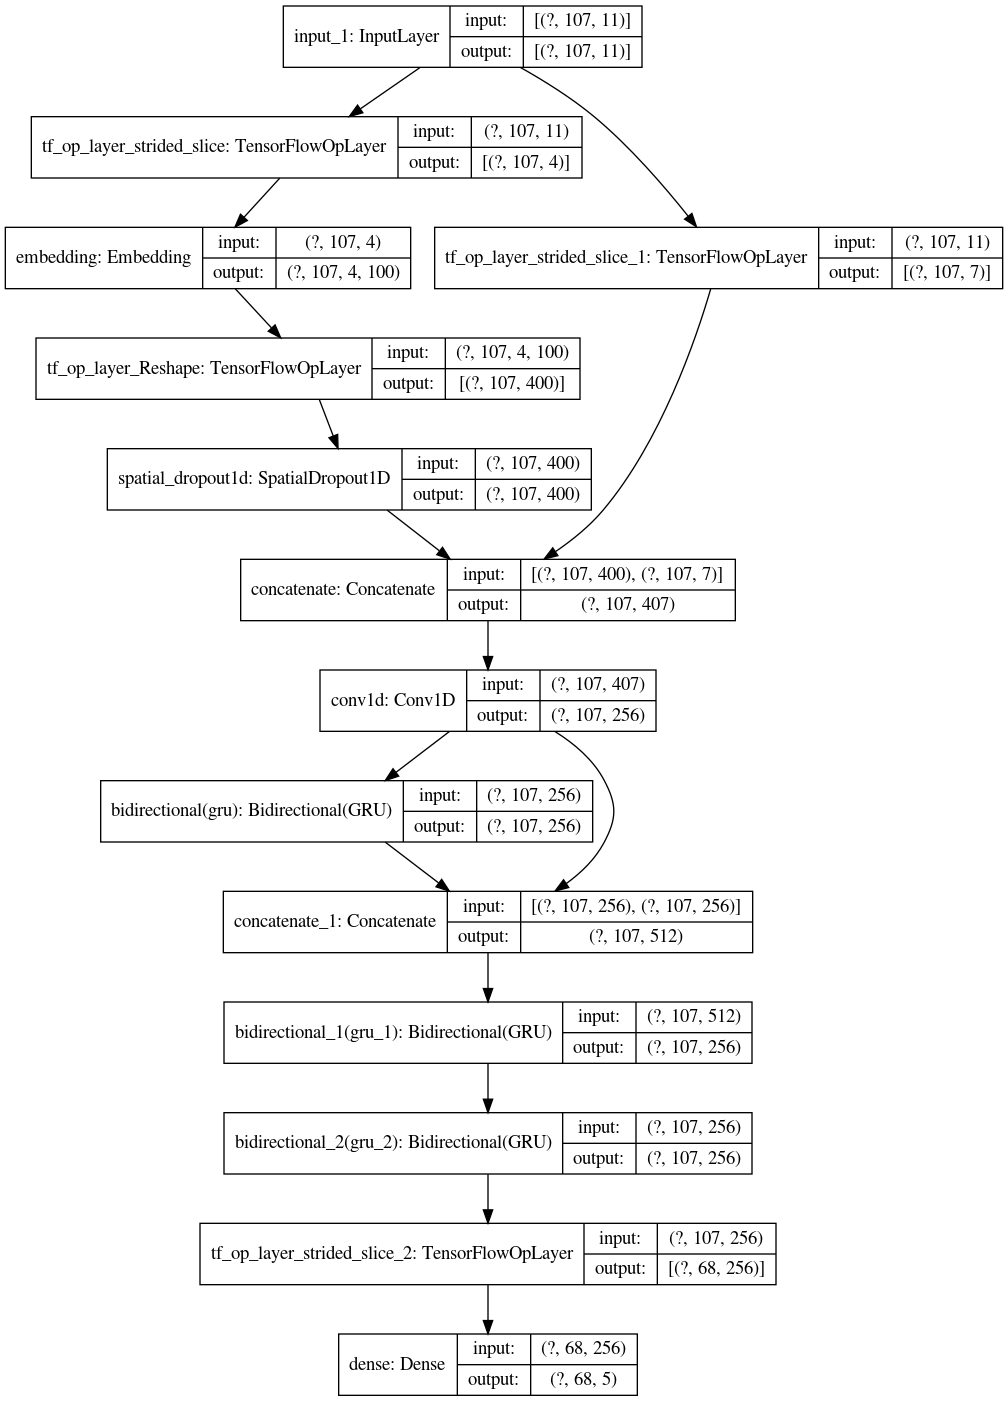

In [29]:
if not TRANSFORMERS:
    plot = tf.keras.utils.plot_model(build_model(),show_shapes=True)
else:
    plot = tf.keras.utils.plot_model(build_transformer(),show_shapes=True)

plot

## 5. LR Schedulers

In [30]:
def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified version of the get_cosine_schedule_with_warmup from huggingface.
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


def build_lrfn(lr_start=EXP_LRSTART, lr_max=EXP_LRMAX, 
               lr_min=EXP_LRMIN, lr_rampup_epochs=EXP_RAMPUP, 
               lr_sustain_epochs=EXP_SUSTAIN, lr_exp_decay=EXP_DECAY):
    
    lr_max = lr_max * BATCH_SIZE
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        
        return lr
    
    return lrfn


class CyclicLR(tf.keras.callbacks.Callback):
    
    def __init__(self,base_lr=0.25e-3,max_lr=1e-3,stepsize=8):
        super().__init__()
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.stepsize = stepsize
        self.iterations = 0
        self.history = {}
        
    def clr(self):
        cycle = np.floor((1+self.iterations)/(2*self.stepsize))
        x = np.abs(self.iterations/self.stepsize - 2*cycle + 1)
        
        return self.base_lr + (self.max_lr - self.base_lr)*(np.maximum(0,1-x))*(1/(2.**(cycle-1)))
    
    def on_train_begin(self,logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
    
    def on_batch_end(self,batch,logs=None):
        logs = logs or {}
        
        self.iterations += 1
        
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

## 6. Training

### Validation Scheme

In [31]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    
    """https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation"""
    
    labels_num = np.max(y)+1
    y = y.astype('int32')
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [32]:
if len(tf.config.list_physical_devices('GPU')):
    print('Training on GPU')
else:
    print('Not on GPU')

Training on GPU


#### Stratified on SNRs
unique SNR Groups:  10
#### Grouped by train.ids

##################################################
#### FOLD:  0
#### Train Shape:  (3153, 107, 11)
#### Validation Shape:  (318, 107, 11)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 107, 11)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 107, 4)]     0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 107, 4, 100)  1500        tf_op_layer_strided_slice_3[0][0]
________________________________________________________________________

Epoch 79/100
99/99 - 4s - loss: 0.2829 - val_loss: 0.2088
Epoch 80/100
99/99 - 4s - loss: 0.2824 - val_loss: 0.2086
Epoch 81/100
99/99 - 4s - loss: 0.2830 - val_loss: 0.2083
Epoch 82/100
99/99 - 4s - loss: 0.2839 - val_loss: 0.2089
Epoch 83/100
99/99 - 4s - loss: 0.2833 - val_loss: 0.2088
Epoch 84/100
99/99 - 4s - loss: 0.2823 - val_loss: 0.2099
Epoch 85/100
99/99 - 4s - loss: 0.2811 - val_loss: 0.2087
Epoch 86/100
99/99 - 4s - loss: 0.2807 - val_loss: 0.2112
Epoch 87/100
99/99 - 4s - loss: 0.2804 - val_loss: 0.2090
Epoch 88/100
99/99 - 4s - loss: 0.2809 - val_loss: 0.2078
Epoch 89/100
99/99 - 4s - loss: 0.2793 - val_loss: 0.2072
Epoch 90/100
99/99 - 4s - loss: 0.2792 - val_loss: 0.2073
Epoch 91/100
99/99 - 4s - loss: 0.2800 - val_loss: 0.2075
Epoch 92/100
99/99 - 4s - loss: 0.2792 - val_loss: 0.2100
Epoch 93/100
99/99 - 4s - loss: 0.2783 - val_loss: 0.2098
Epoch 94/100
99/99 - 4s - loss: 0.2774 - val_loss: 0.2084
Epoch 95/100
99/99 - 4s - loss: 0.2780 - val_loss: 0.2085
Epoch 96/100
9

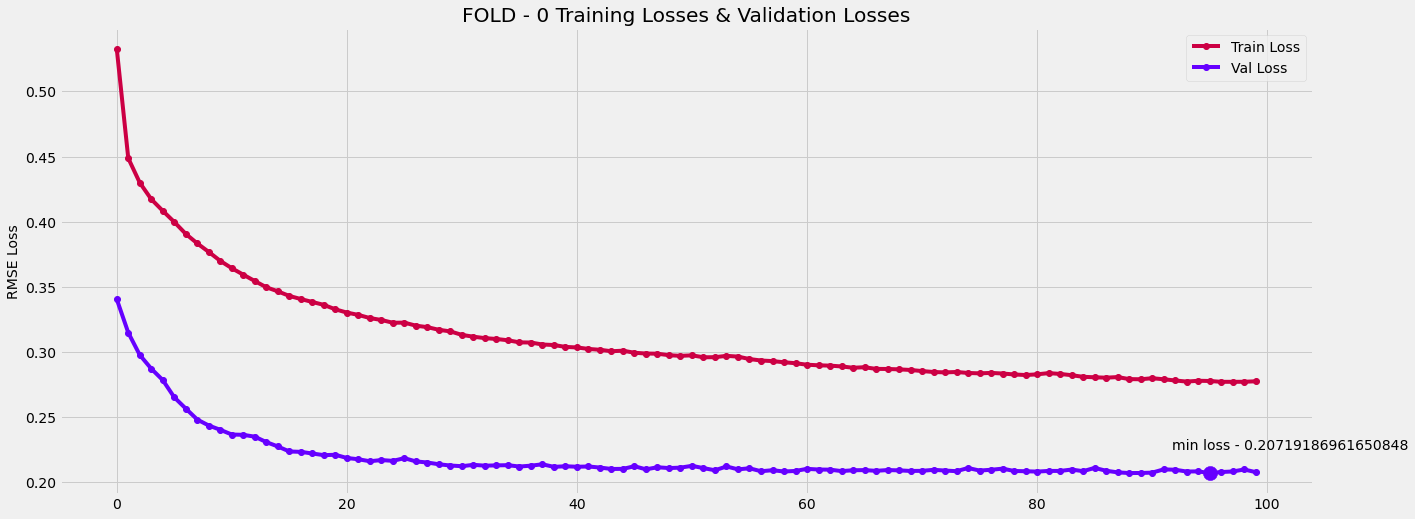


##################################################
#### FOLD:  1
#### Train Shape:  (3157, 107, 11)
#### Validation Shape:  (318, 107, 11)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 107, 11)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_12 (T [(None, 107, 4)]     0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 107, 4, 100)  1500        tf_op_layer_strided_slice_12[0][0
__________________________________________________________________________________________________
tf_op_layer_Reshape_4 (TensorFl [(None, 107, 4

Epoch 80/100
99/99 - 4s - loss: 0.2828 - val_loss: 0.2046
Epoch 81/100
99/99 - 4s - loss: 0.2828 - val_loss: 0.2029
Epoch 82/100
99/99 - 4s - loss: 0.2815 - val_loss: 0.2042
Epoch 83/100
99/99 - 4s - loss: 0.2842 - val_loss: 0.2042
Epoch 84/100
99/99 - 4s - loss: 0.2818 - val_loss: 0.2034
Epoch 85/100
99/99 - 4s - loss: 0.2808 - val_loss: 0.2043
Epoch 86/100
99/99 - 5s - loss: 0.2793 - val_loss: 0.2034
Epoch 87/100
99/99 - 4s - loss: 0.2786 - val_loss: 0.2040
Epoch 88/100
99/99 - 4s - loss: 0.2782 - val_loss: 0.2030
Epoch 89/100
99/99 - 4s - loss: 0.2783 - val_loss: 0.2035
Epoch 90/100
99/99 - 4s - loss: 0.2784 - val_loss: 0.2032
Epoch 91/100
99/99 - 4s - loss: 0.2776 - val_loss: 0.2038
Epoch 92/100
99/99 - 4s - loss: 0.2776 - val_loss: 0.2038
Epoch 93/100
99/99 - 4s - loss: 0.2794 - val_loss: 0.2041
Epoch 94/100
99/99 - 4s - loss: 0.2777 - val_loss: 0.2040
Epoch 95/100
99/99 - 4s - loss: 0.2769 - val_loss: 0.2033
Epoch 96/100
99/99 - 4s - loss: 0.2763 - val_loss: 0.2039
Epoch 97/100
9

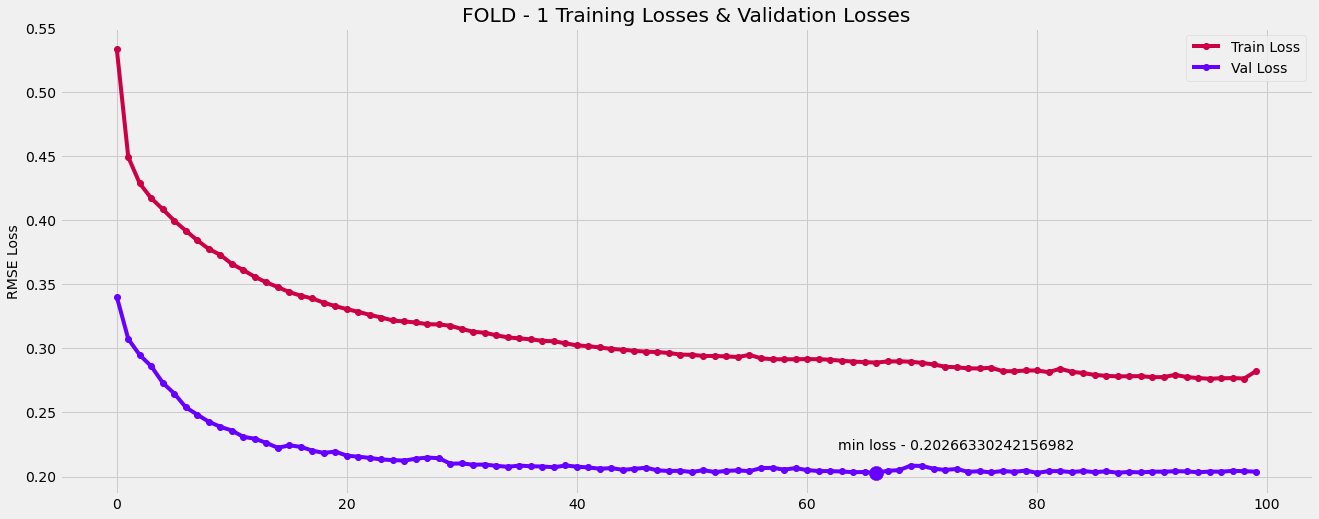


##################################################
#### FOLD:  2
#### Train Shape:  (3159, 107, 11)
#### Validation Shape:  (317, 107, 11)
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 107, 11)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_21 (T [(None, 107, 4)]     0           input_8[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 107, 4, 100)  1500        tf_op_layer_strided_slice_21[0][0
__________________________________________________________________________________________________
tf_op_layer_Reshape_7 (TensorFl [(None, 107, 

Epoch 80/100
99/99 - 4s - loss: 0.2856 - val_loss: 0.2065
Epoch 81/100
99/99 - 4s - loss: 0.2841 - val_loss: 0.2074
Epoch 82/100
99/99 - 4s - loss: 0.2835 - val_loss: 0.2068
Epoch 83/100
99/99 - 4s - loss: 0.2859 - val_loss: 0.2079
Epoch 84/100
99/99 - 4s - loss: 0.2846 - val_loss: 0.2059
Epoch 85/100
99/99 - 4s - loss: 0.2832 - val_loss: 0.2071
Epoch 86/100
99/99 - 4s - loss: 0.2822 - val_loss: 0.2070
Epoch 87/100
99/99 - 4s - loss: 0.2818 - val_loss: 0.2077
Epoch 88/100
99/99 - 4s - loss: 0.2810 - val_loss: 0.2070
Epoch 89/100
99/99 - 5s - loss: 0.2808 - val_loss: 0.2055
Epoch 90/100
99/99 - 4s - loss: 0.2804 - val_loss: 0.2058
Epoch 91/100
99/99 - 5s - loss: 0.2801 - val_loss: 0.2061
Epoch 92/100
99/99 - 4s - loss: 0.2810 - val_loss: 0.2081
Epoch 93/100
99/99 - 4s - loss: 0.2843 - val_loss: 0.2071
Epoch 94/100
99/99 - 4s - loss: 0.2838 - val_loss: 0.2084
Epoch 95/100
99/99 - 4s - loss: 0.2817 - val_loss: 0.2073
Epoch 96/100
99/99 - 4s - loss: 0.2801 - val_loss: 0.2074
Epoch 97/100
9

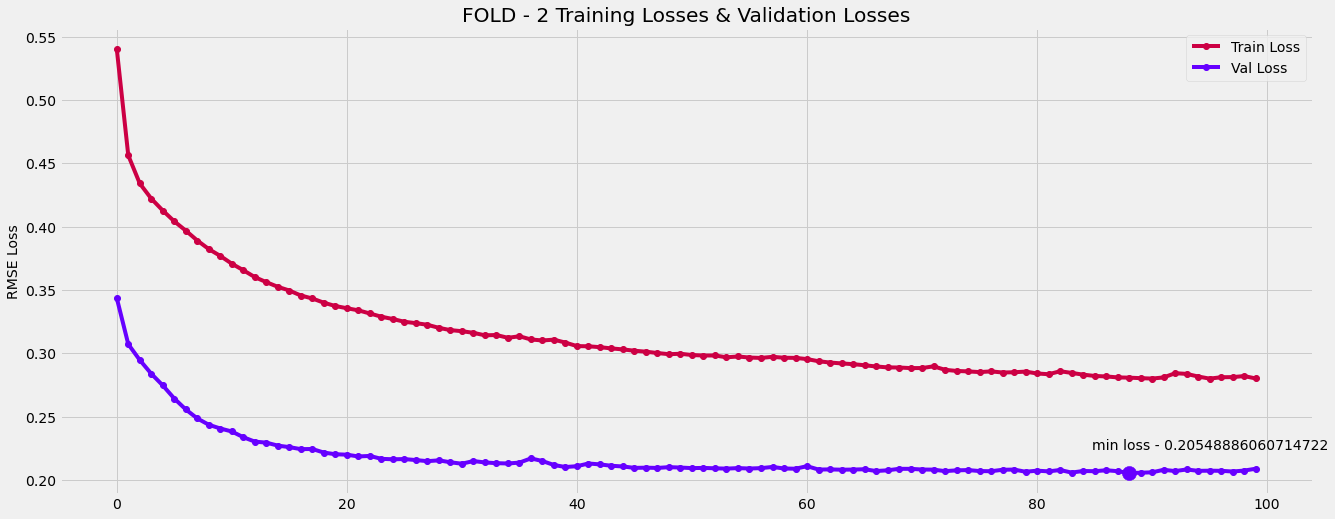


##################################################
#### FOLD:  3
#### Train Shape:  (3160, 107, 11)
#### Validation Shape:  (318, 107, 11)
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 107, 11)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_30 (T [(None, 107, 4)]     0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 107, 4, 100)  1500        tf_op_layer_strided_slice_30[0][0
__________________________________________________________________________________________________
tf_op_layer_Reshape_10 (TensorF [(None, 107, 

Epoch 80/100
99/99 - 4s - loss: 1.0858 - val_loss: 0.2421
Epoch 81/100
99/99 - 4s - loss: 1.0854 - val_loss: 0.2468
Epoch 82/100
99/99 - 4s - loss: 1.0870 - val_loss: 0.2458
Epoch 83/100
99/99 - 4s - loss: 1.0894 - val_loss: 0.2450
Epoch 84/100
99/99 - 4s - loss: 1.0890 - val_loss: 0.2455
Epoch 85/100
99/99 - 4s - loss: 1.0871 - val_loss: 0.2442
Epoch 86/100
99/99 - 4s - loss: 1.0857 - val_loss: 0.2460
Epoch 87/100
99/99 - 4s - loss: 1.0842 - val_loss: 0.2433
Epoch 88/100
99/99 - 4s - loss: 1.0838 - val_loss: 0.2438
Epoch 89/100
99/99 - 5s - loss: 1.0835 - val_loss: 0.2474
Epoch 90/100
99/99 - 5s - loss: 1.0828 - val_loss: 0.2451
Epoch 91/100
99/99 - 5s - loss: 1.0829 - val_loss: 0.2484
Epoch 92/100
99/99 - 4s - loss: 1.0830 - val_loss: 0.2452
Epoch 93/100
99/99 - 4s - loss: 1.0878 - val_loss: 0.2467
Epoch 94/100
99/99 - 4s - loss: 1.0825 - val_loss: 0.2471
Epoch 95/100
99/99 - 4s - loss: 1.0821 - val_loss: 0.2471
Epoch 96/100
99/99 - 4s - loss: 1.0850 - val_loss: 0.2455
Epoch 97/100
9

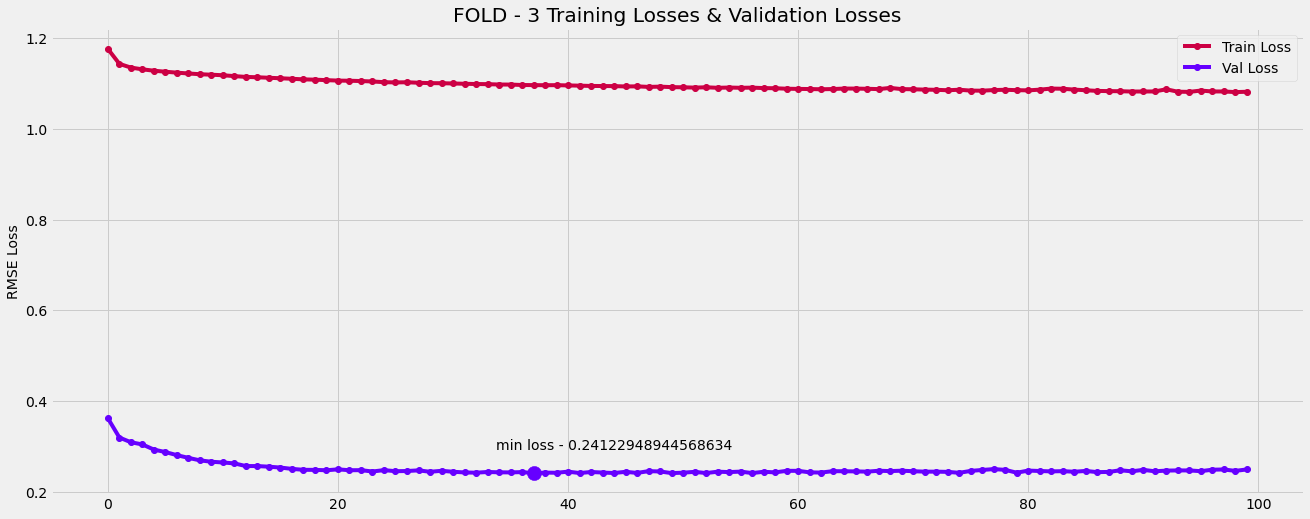


##################################################
#### FOLD:  4
#### Train Shape:  (3163, 107, 11)
#### Validation Shape:  (318, 107, 11)
Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 107, 11)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_39 (T [(None, 107, 4)]     0           input_14[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 107, 4, 100)  1500        tf_op_layer_strided_slice_39[0][0
__________________________________________________________________________________________________
tf_op_layer_Reshape_13 (TensorF [(None, 107, 

Epoch 80/100
99/99 - 4s - loss: 0.2808 - val_loss: 0.2109
Epoch 81/100
99/99 - 4s - loss: 0.2819 - val_loss: 0.2112
Epoch 82/100
99/99 - 4s - loss: 0.2815 - val_loss: 0.2110
Epoch 83/100
99/99 - 4s - loss: 0.2806 - val_loss: 0.2104
Epoch 84/100
99/99 - 4s - loss: 0.2803 - val_loss: 0.2134
Epoch 85/100
99/99 - 4s - loss: 0.2808 - val_loss: 0.2103
Epoch 86/100
99/99 - 4s - loss: 0.2801 - val_loss: 0.2122
Epoch 87/100
99/99 - 4s - loss: 0.2806 - val_loss: 0.2096
Epoch 88/100
99/99 - 4s - loss: 0.2801 - val_loss: 0.2095
Epoch 89/100
99/99 - 4s - loss: 0.2789 - val_loss: 0.2090
Epoch 90/100
99/99 - 4s - loss: 0.2793 - val_loss: 0.2099
Epoch 91/100
99/99 - 4s - loss: 0.2783 - val_loss: 0.2085
Epoch 92/100
99/99 - 4s - loss: 0.2791 - val_loss: 0.2103
Epoch 93/100
99/99 - 4s - loss: 0.2785 - val_loss: 0.2100
Epoch 94/100
99/99 - 4s - loss: 0.2781 - val_loss: 0.2095
Epoch 95/100
99/99 - 4s - loss: 0.2781 - val_loss: 0.2102
Epoch 96/100
99/99 - 4s - loss: 0.2776 - val_loss: 0.2113
Epoch 97/100
9

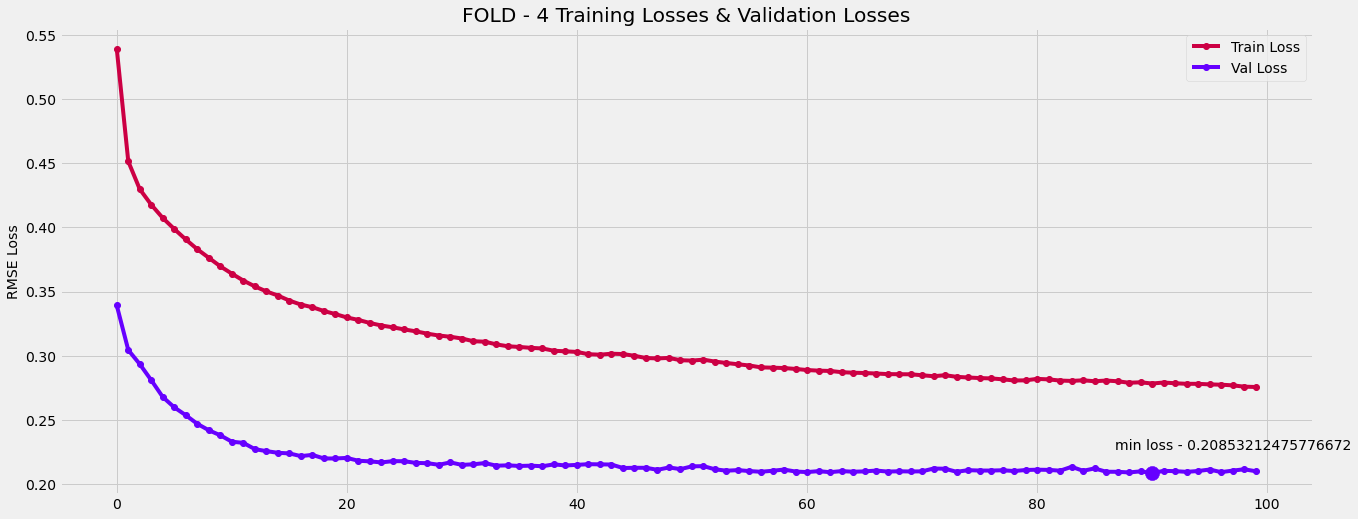

CPU times: user 36min 3s, sys: 3min 5s, total: 39min 8s
Wall time: 38min 25s


In [33]:
%%time

histories = []
private_preds = np.zeros((private_df.shape[0], 130, 5))
public_preds = np.zeros((public_df.shape[0], 107, 5))

oof_pred = []
oof_tar = []
oof_val = []
oof_ids = []

skf = StratifiedKFold(FOLDS, random_state = SEED)

skf_y = train['SN_filter']
if SKF_SNR:
    print("#### Stratified on SNRs")
    skf_y = train['snr_stratify_group']
    print("unique SNR Groups: ",skf_y.nunique())
    
splits = skf.split(train, skf_y)
if AUGMENTED:
    # splits = GroupKFold(FOLDS).split(train,groups=skf_y)
    print("#### Grouped by train.ids")
    splits = stratified_group_k_fold(train,skf_y,train.id,k=FOLDS,seed=SEED)

for fold, (idxT, idxV) in enumerate(splits):
    
    print()
    print("#"*50)
    print("#### FOLD: ",fold)

    X_train, y_train = X[idxT], y[idxT]
    X_val, y_val = X[idxV], y[idxV]
    
    # Filters of Validation Data
    filter_ = train.iloc[idxV].SN_filter==1
    if AUGMENTED:
        filter_ = (train.iloc[idxV].SN_filter==1) & (train.iloc[idxV].cnt == 1)
    
    X_val, y_val = X_val[filter_], y_val[filter_]
    
    oof_ids.append(train.iloc[idxV][filter_]['id'].values)
    oof_tar.append(y[idxV][filter_])
    
    print("#### Train Shape: ",X_train.shape)
    print("#### Validation Shape: ",X_val.shape)
    
#     continue

#     snr = train.iloc[idxT]['signal_to_noise'].values
#     weights = np.abs(snr)
#     weights[weights>1], weights[weights<1] = 1, 2
    
    modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(f'WEIGHTS_FOLD{fold}.h5',monitor='val_loss',mode='min')
    csvLogger = tf.keras.callbacks.CSVLogger(f'TRAININGLOGS_FOLD{fold}.csv')
    
    # LR SCHEDULE
    lr_schedule = get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

    if CYCLIC_LRS:
        lr_schedule = CyclicLR(base_lr=CYCLIC_BLR,max_lr=CYCLIC_MLR,stepsize=CYCLIC_STEP)
    elif EXPDECAY_LRS:
        lrfn = build_lrfn()
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    if not TRANSFORMERS:
        model = build_model()
    else:
        model = build_transformer()
    
    model.summary()
    print()
    print()
    
    if AUGMENTED:
        print("#### Training on Augmented Data: ")
        history = model.fit(getTrainGenerator(X_train,y_train), 
                        validation_data=(X_val,y_val),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
#                         sample_weight = weights,
                        callbacks=[lr_schedule,modelCheckpoint,csvLogger],
                        verbose = VERBOSE)
    else:
        history = model.fit(X_train, y_train, 
                            validation_data=(X_val,y_val),
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
#                             sample_weight = weights,
                            callbacks=[lr_schedule,modelCheckpoint,csvLogger],
                            verbose = VERBOSE)

    histories.append(history)
    
    model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
    
    # VAL PREDICTIONS
    val_preds = model.predict(X_val)
    oof_val.append(np.min(history.history['val_loss']))
    
    oof_pred.append(val_preds)
    
    if INFER_TEST:

        #load best model and predict
        if not TRANSFORMERS:
            public_model = build_model(seq_len=107, pred_len=107)
        else:
            public_model = build_transformer(seq_len=107, pred_len=107)
            
        public_model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
        public_pred = public_model.predict(X_public) / FOLDS

        if not TRANSFORMERS:
            private_model = build_model(seq_len=130, pred_len=130)
        else:
            private_model = build_transformer(seq_len=130, pred_len=130)
        
        private_model.load_weights(f'WEIGHTS_FOLD{fold}.h5')
        private_pred = private_model.predict(X_private) / FOLDS

        public_preds += public_pred
        private_preds += private_pred

        del public_model, private_model
    
    print("#"*50)
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        
        plt.figure(figsize=(20,8))
        
        plt.plot(np.arange(EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#cc0044')
        plt.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#6600ff')
        
        x_ = np.argmin( history.history['val_loss'] ); y_ = np.min( history.history['val_loss'] )
        
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        
        plt.scatter(x_,y_,s=200,color='#6600ff'); plt.text(x_-0.03*xdist,y_+0.05*ydist,f'min loss - {y_}',size=14)
        
        plt.ylabel('RMSE Loss',size=14)
        plt.title(f'FOLD - {fold} Training Losses & Validation Losses')
        plt.legend()
        
        plt.show()
        
    del model
    z = gc.collect()

In [34]:
# Leakage-Check
for i, ids in enumerate(oof_ids):
    print("#ids: ",len(set(ids)))
    for j in range(i+1,len(oof_ids)):
        print(f'Fold_{i} ids intersection Fold_{j} ids: ',len(set(ids).intersection(set(oof_ids[j]))))
    print()

print("Total ids: ",np.concatenate(oof_ids).shape)

#ids:  318
Fold_0 ids intersection Fold_1 ids:  0
Fold_0 ids intersection Fold_2 ids:  0
Fold_0 ids intersection Fold_3 ids:  0
Fold_0 ids intersection Fold_4 ids:  0

#ids:  318
Fold_1 ids intersection Fold_2 ids:  0
Fold_1 ids intersection Fold_3 ids:  0
Fold_1 ids intersection Fold_4 ids:  0

#ids:  317
Fold_2 ids intersection Fold_3 ids:  0
Fold_2 ids intersection Fold_4 ids:  0

#ids:  318
Fold_3 ids intersection Fold_4 ids:  0

#ids:  318

Total ids:  (1589,)


## 7. Inference

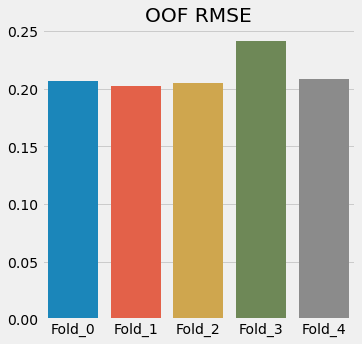

In [35]:
plt.figure(figsize=(5,5))

sns.barplot(x=[f'Fold_{fold}' for fold in range(FOLDS)],y=oof_val)
plt.title('OOF RMSE')

plt.show()

In [36]:
oof_rmse = np.mean(oof_val)

print("Val Losses: ",oof_val)

print(f"Mean Loss: {oof_rmse} +/- {np.std(oof_val)}")

Val Losses:  [0.20719186961650848, 0.20266330242156982, 0.20548886060714722, 0.24122948944568634, 0.20853212475776672]
Mean Loss: 0.21302112936973572 +/- 0.014239822061046807


In [37]:
oof_pred_ = np.transpose(np.array(np.concatenate(oof_pred,axis=0)),(0,2,1))
oof_tar_ = np.transpose(np.concatenate(oof_tar),(0,2,1))

oof_df = pd.DataFrame({
    'id': np.concatenate(oof_ids)
})

for i, target in enumerate(target_cols):
    oof_df[f'{target}'] = list(oof_tar_[:,i,:])
    oof_df[f'pred_{target}'] = list(oof_pred_[:,i,:])

oof_df.head()

,id,reactivity,pred_reactivity,deg_Mg_pH10,pred_deg_Mg_pH10,deg_pH10,pred_deg_pH10,deg_Mg_50C,pred_deg_Mg_50C,deg_50C,pred_deg_50C
0,id_01e2cf40a,"[0.0885, 0.4917, 1.0091, 0.5838, 0.6308, 0.319...","[0.3798892, 0.7104439, 0.83789104, 0.6877659, ...","[0.5652, 1.0096, 0.5626, 0.5263, 0.4265, 0.293...","[0.5115307, 0.9265191, 0.53880554, 0.49818122,...","[2.7149, 1.8073, 0.9468, 1.0909, 0.6464, 0.391...","[3.0617764, 2.123595, 0.9945534, 0.8639574, 0....","[0.2115, 1.393, 0.6087, 0.7529, 0.5446, 0.5488...","[0.41487715, 0.9219454, 0.7267554, 0.70796776,...","[0.5871, 1.6406, 1.0466, 0.7835, 0.6923, 0.212...","[0.5920927, 1.1220834, 0.9702585, 0.99528855, ..."
1,id_01f38f83d,"[0.2409, 0.6422, 0.817, 0.624, 0.3989, 0.1452,...","[0.2597174, 0.69900924, 0.6811634, 0.6267096, ...","[0.3139, 1.0881, 0.9641, 0.4587, 0.2884, 0.382...","[0.4454846, 1.1439224, 0.5567084, 0.38207164, ...","[1.2859, 1.1294, 0.7452, 0.451, 0.3603, 0.4036...","[1.2197846, 1.1471769, 0.6287319, 0.46598333, ...","[0.2833, 1.0513, 0.5702, 0.2063, 0.2736, 0.229...","[0.31221324, 1.1336367, 0.67014855, 0.41369876...","[0.5461, 1.404, 1.0043, 0.852, 0.5093, 0.3388,...","[0.4942109, 1.0666394, 0.83575755, 0.7039495, ..."
2,id_02612d250,"[0.2589, 1.6595, 1.3381, 1.214, 1.0558, 0.4361...","[0.46522003, 1.316354, 1.1738336, 0.94997483, ...","[0.4164, 2.9632, 0.139, 1.1201, 0.4091, 0.5567...","[0.58326733, 2.6906033, 0.3291871, 1.2514719, ...","[2.6594, 4.2289, 0.33, 0.9369, 0.6087, 0.5338,...","[2.1165626, 3.7129626, 0.20770954, 0.9623808, ...","[0.6235, 3.7651, 0.3174, 1.9311, 0.7508, 0.373...","[0.48952064, 3.2249997, 0.14515859, 1.5609266,...","[0.9468, 3.3142, 0.7758, 1.8853, 1.1269, 0.487...","[0.7825191, 3.4393265, 0.6272369, 1.228261, 0...."
3,id_07dcc5ff8,"[0.2343, 0.7147, 0.5304, 0.5352, 0.6371, 0.459...","[0.44430315, 1.4291251, 0.97888434, 0.74746615...","[0.3704, 0.9429, 0.1569, 0.4065, 0.7857, 0.351...","[0.30638525, 1.3984121, 0.1830818, 0.4828159, ...","[1.7813, 1.9396, 0.2663, 0.3861, 0.7424, 0.445...","[1.5917028, 2.8597882, 0.36288634, 0.50863254,...","[0.2455, 1.1524, 0.1583, 0.4763, 0.784, 0.4378...","[0.32836363, 1.952748, 0.17820191, 0.74127233,...","[0.5317, 1.224, 0.4784, 0.5558, 0.8686, 0.5119...","[0.5052952, 2.0065968, 0.6200771, 0.748403, 1...."
4,id_088cef62f,"[0.4268, 1.5837, 1.4222, 0.8576, 0.1081, 0.119...","[0.5567379, 1.3593235, 1.3058133, 0.96818566, ...","[0.5323, 2.2489, 0.7938, 0.5416, 0.5655, 0.154...","[0.47736758, 1.9774611, 0.91892844, 0.5510109,...","[1.4026, 3.2834, 1.1345, 0.9945, 0.5993, 0.206...","[1.9968612, 3.1650236, 1.2045041, 0.79135615, ...","[0.2887, 2.1497, 0.8337, 0.9057, 1.2197, 0.175...","[0.4586471, 1.9444696, 1.2261198, 0.8699358, 1...","[0.4534, 1.5328, 1.1025, 0.8581, 0.4845, 0.257...","[0.69322234, 1.7885101, 1.3249803, 1.0457826, ..."


In [38]:
def preprocess(df):
    
    data = []
    
    for index in tqdm(range(df.shape[0])):
        sample = df.iloc[index]
        
        seq_length = 68
        
        for i in range(seq_length):
            preprocessed = {
                'id': sample.id,
                'id_seqpos': sample.id + '_' + str(i),
            }
            
                
            for col in target_cols:
                preprocessed[col] = sample[col][i]
                preprocessed[f'pred_{col}'] = sample[f'pred_{col}'][i]
            
            data.append(preprocessed)
    
    data = pd.DataFrame(data)
    
    return data

oof_df_ = preprocess(oof_df)

oof_df_.head()

100%|██████████| 1589/1589 [00:09<00:00, 160.81it/s]


,id,id_seqpos,reactivity,pred_reactivity,deg_Mg_pH10,pred_deg_Mg_pH10,deg_pH10,pred_deg_pH10,deg_Mg_50C,pred_deg_Mg_50C,deg_50C,pred_deg_50C
0,id_01e2cf40a,id_01e2cf40a_0,0.0885,0.379889,0.5652,0.511531,2.7149,3.061776,0.2115,0.414877,0.5871,0.592093
1,id_01e2cf40a,id_01e2cf40a_1,0.4917,0.710444,1.0096,0.926519,1.8073,2.123595,1.3930,0.921945,1.6406,1.122083
2,id_01e2cf40a,id_01e2cf40a_2,1.0091,0.837891,0.5626,0.538806,0.9468,0.994553,0.6087,0.726755,1.0466,0.970258
3,id_01e2cf40a,id_01e2cf40a_3,0.5838,0.687766,0.5263,0.498181,1.0909,0.863957,0.7529,0.707968,0.7835,0.995289
4,id_01e2cf40a,id_01e2cf40a_4,0.6308,0.741025,0.4265,0.454379,0.6464,0.712513,0.5446,0.573043,0.6923,0.873730


In [39]:
scored_cols = ['reactivity','deg_Mg_50C','deg_Mg_pH10']

scored_rmse = 0

for col in scored_cols:
    col_rmse = np.sqrt(np.mean((oof_df_[col] - oof_df_[f'pred_{col}'])**2))
    print(f"{col} RMSE: ",col_rmse)
    scored_rmse += col_rmse
    
scored_rmse /= len(scored_cols)

print("\nRMSE on Scored Targets (Whole Train data): ",scored_rmse)
print()
print("#"*50)
print()

SN_FILTER = train[['id','SN_filter']]
if AUGMENTED:
    SN_FILTER = train[train.cnt==1][['id','SN_filter']]

oof_df_filtered = oof_df_.merge(SN_FILTER,on='id',how='left')
oof_df_filtered = oof_df_filtered[oof_df_filtered.SN_filter==1]

filtered_scored_rmse = 0

for col in scored_cols:
    col_rmse = np.sqrt(np.mean((oof_df_filtered[col] - oof_df_filtered[f'pred_{col}'])**2))
    print(f"{col} RMSE: ",col_rmse)
    filtered_scored_rmse += col_rmse
    
filtered_scored_rmse /= len(scored_cols)

print("RMSE on Scored Targets (Filtered Data): ",filtered_scored_rmse)

reactivity RMSE:  0.21332149359659683
deg_Mg_50C RMSE:  0.220755019346457
deg_Mg_pH10 RMSE:  0.26546846954198156

RMSE on Scored Targets (Whole Train data):  0.23318166082834513

##################################################

reactivity RMSE:  0.21332149359659683
deg_Mg_50C RMSE:  0.220755019346457
deg_Mg_pH10 RMSE:  0.26546846954198156
RMSE on Scored Targets (Filtered Data):  0.23318166082834513


In [40]:
oof_df_.to_csv(f'oof_{oof_rmse}_{scored_rmse}_{filtered_scored_rmse}.csv',index=False)

### 8. Test set Predictions

In [41]:
test_preds = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        test_preds.append(single_df)

test_preds_df = pd.concat(test_preds)
test_preds_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.721219,0.630818,1.899849,0.540164,0.693511,id_00073f8be_0
1,2.152375,3.178208,3.872319,3.130266,2.538820,id_00073f8be_1
2,1.398012,0.512405,0.620175,0.621889,0.653833,id_00073f8be_2
3,1.205574,1.078343,1.160261,1.563113,1.698380,id_00073f8be_3
4,0.726833,0.564324,0.533283,0.810658,0.878944,id_00073f8be_4


In [42]:
submission = sub[['id_seqpos']].merge(test_preds_df, on=['id_seqpos'])

submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.721219,0.630818,1.899849,0.540164,0.693511
1,id_00073f8be_1,2.152375,3.178208,3.872319,3.130266,2.538820
2,id_00073f8be_2,1.398012,0.512405,0.620175,0.621889,0.653833
3,id_00073f8be_3,1.205574,1.078343,1.160261,1.563113,1.698380
4,id_00073f8be_4,0.726833,0.564324,0.533283,0.810658,0.878944


In [43]:
submission.to_csv(f'submission_{oof_rmse}_{scored_rmse}_{filtered_scored_rmse}.csv', index=False)